<center><h2>
    Supervised Learning: MLB Pitches
    </h2></center>

In this project, I will be creating a predictive model based on MLB pitches. The data I will be providing comes from <a href="https://www.kaggle.com/pschale/mlb-pitch-data-20152018#pitches.csv">Kaggle</a>, and covers MLB pitches recorded between 2015 and 2018 along with other related data. The model will use variables to make a binary prediction whether the pitch about to be thrown will be a fastball or not. I also test several different models to see which produces the highest scoring results.

<center><h2>
    Exploratory Data Analysis
    </h2></center>

In [1]:
# Imports here
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import seaborn as sns
from sklearn.svm import SVC
sns.set()
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import boxcox
from sklearn.preprocessing import QuantileTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_recall_curve, roc_auc_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Get rid of exponential notation in dataframes
pd.set_option('display.precision',10)

In [55]:
pitches_df = pd.read_csv(r'C:\Users\Brian\Desktop\pitches.csv')

In [56]:
atbat_df = pd.read_csv (r'C:\Users\Brian\Desktop\atbats.csv')

In [5]:
pitches_df.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,3,0.0,2015000001.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,4,0.0,2015000001.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,...,5,0.0,2015000001.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,...,6,0.0,2015000001.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,...,7,0.0,2015000001.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0


In [57]:
pitches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867154 entries, 0 to 2867153
Data columns (total 40 columns):
px                 float64
pz                 float64
start_speed        float64
end_speed          float64
spin_rate          float64
spin_dir           float64
break_angle        float64
break_length       float64
break_y            float64
ax                 float64
ay                 float64
az                 float64
sz_bot             float64
sz_top             float64
type_confidence    float64
vx0                float64
vy0                float64
vz0                float64
x                  float64
x0                 float64
y                  float64
y0                 float64
z0                 float64
pfx_x              float64
pfx_z              float64
nasty              float64
zone               float64
code               object
type               object
pitch_type         object
event_num          int64
b_score            float64
ab_id              float64
b

In [6]:
atbat_df.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [58]:
atbat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740389 entries, 0 to 740388
Data columns (total 11 columns):
ab_id         740389 non-null int64
batter_id     740389 non-null int64
event         740389 non-null object
g_id          740389 non-null int64
inning        740389 non-null int64
o             740389 non-null int64
p_score       740389 non-null int64
p_throws      740389 non-null object
pitcher_id    740389 non-null int64
stand         740389 non-null object
top           740389 non-null bool
dtypes: bool(1), int64(7), object(3)
memory usage: 57.2+ MB


In [7]:
# Joining two data frames on ab_id, inner join drops rows with nulls which I prefer to dropping columns to
# keep more independent variables. Even though I'm dropping 75% of my data, 750000 entries was still more than sufficient
# as I later end up subsampling it into an even smaller amount
df_joined = pd.concat([pitches_df, atbat_df], join='inner', axis=1)
df_joined.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,518792,Double,201500001,1,1,0,L,452657,L,True
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,...,407812,Single,201500001,1,1,0,L,452657,R,True
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,...,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,...,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [8]:
# Creating dataframe I will be cleaning using only the columns needed for feature engineering
df = df_joined[['pitch_type','b_score', 'p_score', 'b_count', 's_count', 'pitch_num', 'outs', 'on_1b', 'on_2b', 'on_3b',
                'inning', 'p_throws', 'stand']]

In [9]:
df.head()

,pitch_type,b_score,p_score,b_count,s_count,pitch_num,outs,on_1b,on_2b,on_3b,inning,p_throws,stand
0,FF,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,L,L
1,FF,0.0,0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1,L,L
2,FF,0.0,0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,1,L,R
3,FF,0.0,0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,1,L,R
4,CU,0.0,0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,1,L,L


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740389 entries, 0 to 740388
Data columns (total 13 columns):
pitch_type    739328 non-null object
b_score       740389 non-null float64
p_score       740389 non-null int64
b_count       740389 non-null float64
s_count       740389 non-null float64
pitch_num     740389 non-null float64
outs          740389 non-null float64
on_1b         740389 non-null float64
on_2b         740389 non-null float64
on_3b         740389 non-null float64
inning        740389 non-null int64
p_throws      740389 non-null object
stand         740389 non-null object
dtypes: float64(8), int64(2), object(3)
memory usage: 73.4+ MB


In [11]:
df.isnull().sum()

pitch_type    1061
b_score          0
p_score          0
b_count          0
s_count          0
pitch_num        0
outs             0
on_1b            0
on_2b            0
on_3b            0
inning           0
p_throws         0
stand            0
dtype: int64

In [12]:
# I choose to drop all nulls since it's a small amount
df.dropna(inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739328 entries, 0 to 740388
Data columns (total 13 columns):
pitch_type    739328 non-null object
b_score       739328 non-null float64
p_score       739328 non-null int64
b_count       739328 non-null float64
s_count       739328 non-null float64
pitch_num     739328 non-null float64
outs          739328 non-null float64
on_1b         739328 non-null float64
on_2b         739328 non-null float64
on_3b         739328 non-null float64
inning        739328 non-null int64
p_throws      739328 non-null object
stand         739328 non-null object
dtypes: float64(8), int64(2), object(3)
memory usage: 79.0+ MB


In [14]:
# Defining my outcome variable fastball, the four pitch types listed are all different types of fastballs
df['fastball'] = df['pitch_type'].isin(['FF', 'FT', 'FC', 'FS'])

In [15]:
# Creating a feature that checks whether the previous row's pitch is a fastball. I verified the rows are related by ab_id
df['prev_pitch_fast'] = np.where(df['fastball'].shift(1) == True,1,0)
df.loc[df['pitch_num']==1.0,['prev_pitch_fast']] = 0

In [16]:
df.head(15)

,pitch_type,b_score,p_score,b_count,s_count,pitch_num,outs,on_1b,on_2b,on_3b,inning,p_throws,stand,fastball,prev_pitch_fast
0,FF,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,L,L,True,0
1,FF,0.0,0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1,L,L,True,1
2,FF,0.0,0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,1,L,R,True,1
3,FF,0.0,0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,1,L,R,True,1
4,CU,0.0,0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,1,L,L,False,1
5,FF,0.0,1,2.0,2.0,6.0,0.0,0.0,0.0,0.0,1,R,L,True,0
6,FF,0.0,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,R,R,True,0
7,FC,0.0,1,1.0,0.0,2.0,1.0,0.0,0.0,0.0,1,R,L,True,1
8,FF,0.0,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1,R,R,True,0
9,FF,0.0,0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,2,L,R,True,1


In [17]:
# Initial data is too large with my limitations, 50000 samples is also sufficient amount
df = df.sample(n=50000).copy()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 693879 to 364868
Data columns (total 15 columns):
pitch_type         50000 non-null object
b_score            50000 non-null float64
p_score            50000 non-null int64
b_count            50000 non-null float64
s_count            50000 non-null float64
pitch_num          50000 non-null float64
outs               50000 non-null float64
on_1b              50000 non-null float64
on_2b              50000 non-null float64
on_3b              50000 non-null float64
inning             50000 non-null int64
p_throws           50000 non-null object
stand              50000 non-null object
fastball           50000 non-null bool
prev_pitch_fast    50000 non-null int32
dtypes: bool(1), float64(8), int32(1), int64(2), object(3)
memory usage: 5.6+ MB


In [19]:
# The next few rows are some feature engineering work in which I create new features
df['same_side'] = (df['p_throws'] == df['stand'])

In [20]:
df.drop(columns=['p_throws', 'stand', 'pitch_type'], inplace=True)

In [21]:
df['pitcher_losing'] = (df['p_score'] < df['b_score'])

In [22]:
df['RISP'] = (df['on_2b'] + df['on_3b'] > 0)

In [23]:
df.head(10)

,b_score,p_score,b_count,s_count,pitch_num,outs,on_1b,on_2b,on_3b,inning,fastball,prev_pitch_fast,same_side,pitcher_losing,RISP
693879,2.0,4,1.0,0.0,2.0,1.0,0.0,0.0,0.0,7,False,0,False,False,False
105722,0.0,1,0.0,1.0,2.0,1.0,0.0,0.0,0.0,4,True,1,True,False,False
119079,2.0,5,2.0,2.0,5.0,0.0,0.0,0.0,0.0,9,True,1,False,False,False
381145,3.0,0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,4,True,0,True,True,False
47346,0.0,0,3.0,1.0,5.0,2.0,0.0,0.0,0.0,8,True,0,False,False,False
70255,5.0,2,0.0,1.0,2.0,1.0,1.0,1.0,0.0,8,False,0,False,True,True
233940,0.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,8,False,0,True,False,False
481520,0.0,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9,False,0,True,False,False
354587,0.0,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1,True,0,False,False,False
33558,5.0,5,1.0,0.0,2.0,2.0,1.0,1.0,0.0,3,True,1,False,False,True


In [24]:
# Checked for imbalance, concluded data is not imbalanced
df['fastball'].value_counts()

True     27071
False    22929
Name: fastball, dtype: int64

In [25]:
# I used quantile transformation on some non-normal distributions as some columns have a lot of 0's,
# distributions are still bimodal but better than initial
quantile = QuantileTransformer(output_distribution='normal')
df['b_score'] = quantile.fit_transform(df[['b_score']])
df['p_score'] = quantile.fit_transform(df[['p_score']])
df['b_count'] = quantile.fit_transform(df[['b_count']])
df['pitch_num'] = quantile.fit_transform(df[['pitch_num']])

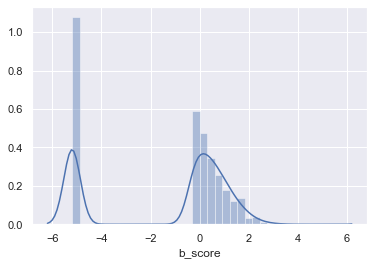

In [26]:
sns.distplot(df['b_score'])

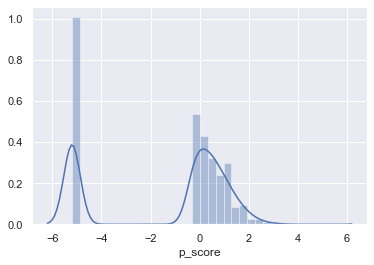

In [27]:
sns.distplot(df['p_score']) 

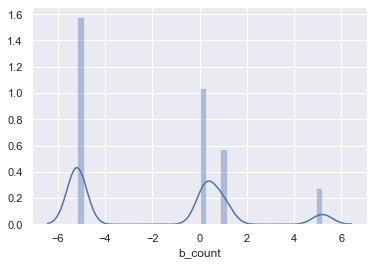

In [28]:
sns.distplot(df['b_count'])

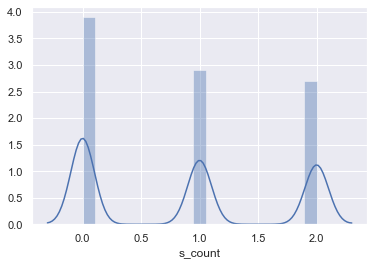

In [29]:
sns.distplot(df['s_count'])

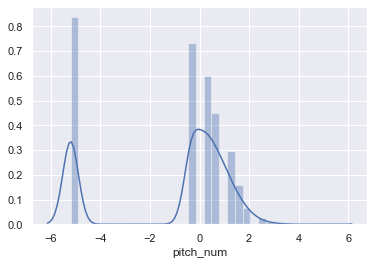

In [30]:
sns.distplot(df['pitch_num'])

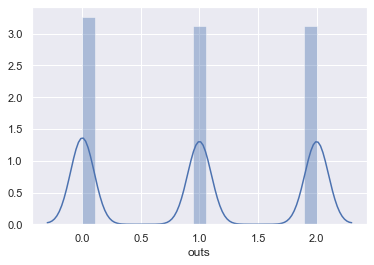

In [31]:
sns.distplot(df['outs'])

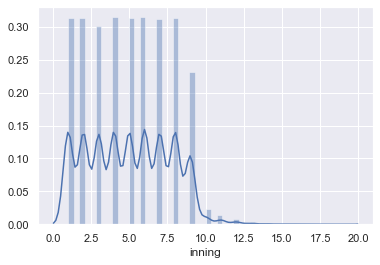

In [32]:
sns.distplot(df['inning'])

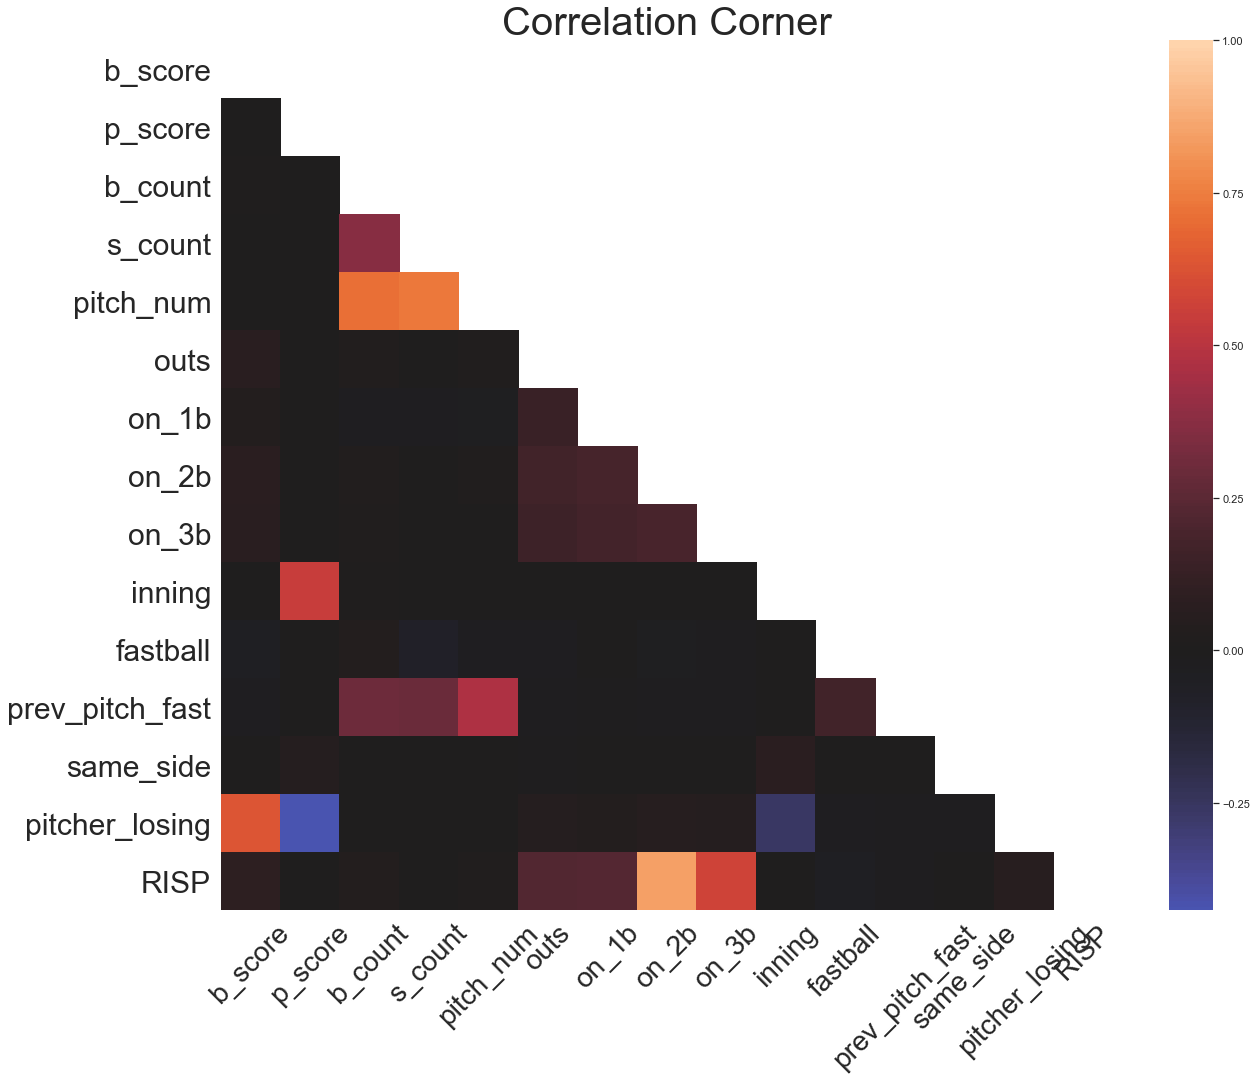

In [33]:
corr = df.corr()
corr_mask = np.corrcoef(corr)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr, mask=mask, center=0)
    plt.title("Correlation Corner", fontsize=40)
    plt.xticks(fontsize=28, rotation=45)
    plt.yticks(fontsize=30, rotation=0)
    plt.show()

In [34]:
df.columns

Index(['b_score', 'p_score', 'b_count', 's_count', 'pitch_num', 'outs',
       'on_1b', 'on_2b', 'on_3b', 'inning', 'fastball', 'prev_pitch_fast',
       'same_side', 'pitcher_losing', 'RISP'],
      dtype='object')

<center><h2>
    Model Comparison
    </h2></center

In [35]:
# Fastball is my output variable. RISP, inning, and pitch_num had multicollinearity and dropping them improved model performance
y = df['fastball']
X = df.drop(columns=['fastball', 'RISP', 'inning', 'pitch_num'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [36]:
y.value_counts()

True     27071
False    22929
Name: fastball, dtype: int64

In [37]:
# making room for cpu memory
del df_joined, pitches_df, atbat_df

In [38]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df', 4800024),
 ('X', 3900024),
 ('X_train', 3120024),
 ('X_test', 780024),
 ('y', 450024),
 ('y_train', 360024),
 ('y_test', 90024),
 ('corr', 3045),
 ('corr_mask', 1912),
 ('mask', 1912),
 ('QuantileTransformer', 1184),
 ('Counter', 1056),
 ('GradientBoostingClassifier', 1056),
 ('GridSearchCV', 1056),
 ('KNeighborsClassifier', 1056),
 ('LogisticRegression', 1056),
 ('RandomForestClassifier', 1056),
 ('RandomizedSearchCV', 1056),
 ('SMOTE', 1056),
 ('SVC', 1056),
 ('boxcox', 136),
 ('classification_report', 136),
 ('confusion_matrix', 136),
 ('f1_score', 136),
 ('precision_recall_curve', 136),
 ('roc_auc_score', 136),
 ('roc_curve', 136),
 ('train_test_split', 136),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('quantile', 56)]

In [39]:
# function to format confusion matrices as dataframes
def conf_matrix(y_true, y_predict):
  data = confusion_matrix(y_true, y_predict)
  index = ['Actual_0', 'Actual_1']
  columns = ['Predicted_0', 'Predicted_1']
  return pd.DataFrame(data, index, columns)

<h2>
    Gradient Boosting Classifier
    </h2>

In [ ]:
# GBC is the model I primarily use, thus I go more in depth with this and also include visualizations

In [41]:
# parameters are tuned from gridsearchcv below
gbc = GradientBoostingClassifier(learning_rate=.06, max_depth=4, n_estimators=65)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.06, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=65,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [42]:
gbc.score(X_train, y_train), gbc.score(X_test, y_test)

(0.61275, 0.6002)

In [43]:
gbc_y_test_predict = gbc.predict(X_test)
gbc_y_train_predict = gbc.predict(X_train)

In [44]:
conf_matrix(y_test, gbc_y_test_predict)

,Predicted_0,Predicted_1
Actual_0,2003,2647
Actual_1,1351,3999


boost precision to reduce false positives

In [45]:
f1_score(y_train, gbc_y_train_predict, average='binary'), f1_score(y_test, gbc_y_test_predict, average='binary')

(0.6813150639838702, 0.6667222407469157)

In [53]:
print((classification_report(y_test, gbc_y_test_predict)))

              precision    recall  f1-score   support

       False       0.60      0.43      0.50      4650
        True       0.60      0.75      0.67      5350

    accuracy                           0.60     10000
   macro avg       0.60      0.59      0.58     10000
weighted avg       0.60      0.60      0.59     10000



In [47]:
print(classification_report(y_train, gbc_y_train_predict))

              precision    recall  f1-score   support

       False       0.61      0.44      0.51     18279
        True       0.62      0.76      0.68     21721

    accuracy                           0.61     40000
   macro avg       0.61      0.60      0.59     40000
weighted avg       0.61      0.61      0.60     40000



In [48]:
gbc_params = {'learning_rate':[.06], 'max_depth':[4], 'n_estimators':[65]} 
gbc_grid = GridSearchCV(gbc, param_grid=gbc_params, cv=3, scoring='roc_auc', n_jobs=8)
gbc_grid.fit(X_train, y_train)
print(gbc_grid.best_params_) 
print(gbc_grid.best_score_)

{'learning_rate': 0.06, 'max_depth': 4, 'n_estimators': 65}
0.6405221466865799


In [50]:
gbc_params = {'learning_rate':[.05,.08,.1], 'max_depth':[4], 'n_estimators':[60,65,70]} 
gbc_grid_2 = RandomizedSearchCV(gbc, param_distributions=gbc_params, cv=3, scoring='roc_auc', n_jobs=8)
gbc_grid_2.fit(X_train, y_train)
print(gbc_grid_2.best_params_) 
print(gbc_grid_2.best_score_)

{'n_estimators': 65, 'max_depth': 4, 'learning_rate': 0.05}
0.6404447908217779


In [51]:
# seeing which features have higher importance scores
pd.DataFrame({'columns': X_train.columns, 'importance scores':gbc_grid.best_estimator_.feature_importances_}).sort_values(
    by='importance scores', ascending=False)

,columns,importance scores
8,prev_pitch_fast,0.3867542377
3,s_count,0.2861681341
2,b_count,0.1970538692
0,b_score,0.0438142617
6,on_2b,0.0285955265
4,outs,0.0190313066
1,p_score,0.0139973936
7,on_3b,0.0139800580
5,on_1b,0.0080595131
10,pitcher_losing,0.0018094261


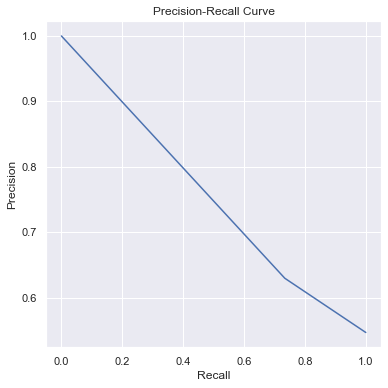

In [52]:
pres, rec, thresholds = precision_recall_curve(y_test, gbc_y_test_predict)
fig = plt.figure(figsize = (6, 6))
plt.plot(rec, pres)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [53]:
train_probs = gbc.predict_proba(X_train)[:,1]
test_probs = gbc.predict_proba(X_test)[:,1]

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
print(fpr[1:30])
print(tpr[1:30])
print(thresholds[1:30])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00022065
 0.00022065 0.00022065 0.00088261 0.00088261 0.00110327 0.00110327
 0.00110327 0.00110327 0.00132392 0.00132392 0.00154457 0.00154457
 0.00154457 0.00154457 0.00176523 0.00198588 0.00198588]
[0.00073153 0.00182882 0.00219459 0.00274323 0.003109   0.00365764
 0.00402341 0.0051207  0.00585223 0.006218   0.00658376 0.00676664
 0.00713241 0.00841258 0.00859546 0.00877835 0.00914411 0.00987564
 0.0102414  0.0113387  0.0113387  0.01207023 0.01207023 0.01261887
 0.01408193 0.01426481 0.01499634 0.01554499 0.01609364]
[0.93821645 0.9374227  0.93351373 0.93266389 0.93068752 0.92980427
 0.92659031 0.92542565 0.92141318 0.91737794 0.91288339 0.9125679
 0.91229731 0.90718936 0.90707535 0.90673626 0.90644468 0.89610628
 0.89570471 0.87465657 0.87439505 0.86867592 0.86598532 0.85220154
 0.85047884 0.84848032 0.84839171 0.84749613 0.84626033]


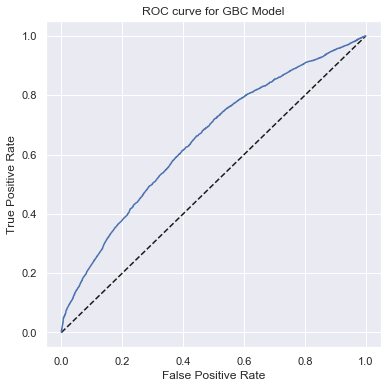

In [55]:
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for GBC Model')
plt.show()

In [56]:
roc_auc_score(y_test, test_probs)

0.6481882513424815

The rest of these models include F1 scores, confusion matrices and gridsearchcv to show comparison

<h2>
Random Forest Classifier
</h2>

In [40]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.887425, 0.5197)

In [42]:
rfc_y_test_predict = rfc.predict(X_test)

In [43]:
conf_matrix(y_test, rfc_y_test_predict)

,Predicted_0,Predicted_1
Actual_0,2180,2286
Actual_1,2517,3017


In [113]:
f1_score(y_test, rfc_y_test_predict, average='binary')

0.5567961612992525

In [45]:
rfc_params = {'max_features':[10, 11, 12], 'max_depth':[8, 9, 10], 'n_estimators':[86, 87, 88]} 
rfc_grid = GridSearchCV(rfc, param_grid=rfc_params, cv=3, n_jobs=8)
rfc_grid.fit(X_train, y_train)
print(rfc_grid.best_params_)
print(rfc_grid.best_score_)

In [62]:
tuned_rfc = RandomForestClassifier(max_features=10, max_depth=8, n_estimators=87)
tuned_rfc.fit(X_train, y_train)

In [47]:
tuned_rfc_y_test_predict = tuned_rfc.predict(X_test)

In [48]:
tuned_rfc.score(X_train, y_train), tuned_rfc.score(X_test, y_test)

(0.595175, 0.5641)

In [104]:
f1_score(y_test, tuned_rfc_y_test_predict, average='binary')

0.6407318882386878

In [50]:
conf_matrix(y_test, tuned_rfc_y_test_predict)

,Predicted_0,Predicted_1
Actual_0,1754,2712
Actual_1,1647,3887


<h2>
Support Vector Classifier
    </h2>

In [51]:
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [52]:
svc.score(X_train, y_train), svc.score(X_test, y_test)

(0.583325, 0.5585)

In [53]:
svc_y_test_predict = svc.predict(X_test)

In [54]:
conf_matrix(y_test, svc_y_test_predict)

,Predicted_0,Predicted_1
Actual_0,1436,3030
Actual_1,1385,4149


In [114]:
f1_score(y_test, svc_y_test_predict, average='binary')

0.6527176905529773

In [117]:
svc_params = {'C':[6,10]} 
svc_grid = GridSearchCV(svc, param_grid=svc_params, cv=3, n_jobs=8)
svc_grid.fit(X_train, y_train)
print(svc_grid.best_params_) 
print(svc_grid.best_score_)

KeyboardInterrupt: 

In [63]:
tuned_svc = SVC(C=2)
tuned_svc.fit(X_train, y_train)

In [58]:
tuned_svc.score(X_train, y_train), tuned_svc.score(X_test, y_test)

(0.5949, 0.5597)

In [59]:
tuned_svc_y_test_predict = tuned_svc.predict(X_test)

In [103]:
f1_score(y_test, tuned_svc_y_test_predict, average='binary')

0.6483507707052153

In [61]:
conf_matrix(y_test, tuned_svc_y_test_predict)

,Predicted_0,Predicted_1
Actual_0,1538,2928
Actual_1,1475,4059


<h2>
KNN Classifier
</h2>

In [64]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

In [64]:
knn.score(X_train, y_train), knn.score(X_test, y_test)

(0.694, 0.5272)

In [65]:
knn_y_test_predict = knn.predict(X_test)

In [102]:
f1_score(y_test, knn_y_test_predict, average='binary')

0.5843881856540084

In [67]:
conf_matrix(y_test, knn_y_test_predict)

,Predicted_0,Predicted_1
Actual_0,1948,2518
Actual_1,2210,3324


In [76]:
knn_params = {'n_neighbors':[27,28,29]} 
knn_grid = GridSearchCV(knn, param_grid=knn_params, cv=3, n_jobs=8)
knn_grid.fit(X_train, y_train)
print(knn_grid.best_params_) 
print(knn_grid.best_score_)

{'n_neighbors': 28}
0.5295987163662811


In [65]:
tuned_knn=KNeighborsClassifier(n_neighbors=28)
tuned_knn.fit(X_train, y_train)

In [78]:
tuned_knn.score(X_train, y_train), tuned_knn.score(X_test, y_test)

(0.5974, 0.5369)

In [79]:
tuned_knn_y_predict = tuned_knn.predict(X_test)

In [105]:
f1_score(y_test, tuned_knn_y_predict, average='binary')

0.5901407204177361

In [82]:
conf_matrix(y_test, tuned_knn_y_predict)

,Predicted_0,Predicted_1
Actual_0,2035,2431
Actual_1,2200,3334


<h2>
    Logistic Regression
    </h2>

In [66]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced')
lr.fit(X_train, y_train)

In [109]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.5493, 0.5517)

In [110]:
lr_y_test_predict = lr.predict(X_test)

In [111]:
conf_matrix(y_test, lr_y_test_predict)

,Predicted_0,Predicted_1
Actual_0,2320,2146
Actual_1,2337,3197


In [112]:
f1_score(y_test, lr_y_test_predict, average='binary')

0.5878459133952377

In [69]:
lr_params = {'C':[.01, .1, 1, 10]} 
lr_grid = GridSearchCV(lr, param_grid=lr_params, cv=3, n_jobs=8)
lr_grid.fit(X_train, y_train)
print(lr_grid.best_params_) 
print(lr_grid.best_score_)

Here, I compare both F1 scores and run times. SVC would have been a consideration if it weren't for the inefficient run time.

In [77]:
class timeit():
    from datetime import datetime
    def __enter__(self):
        self.tic = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('{}'.format(self.datetime.now() - self.tic))

In [80]:
print('RFC Run Time:')
with timeit():
    tuned_rfc.fit(X_train, y_train)
print('SVC Run Time:')
with timeit():
    tuned_svc.fit(X_train, y_train)
print('KNN Run Time:')
with timeit():
    tuned_knn.fit(X_train, y_train)
print('LR Run Time:')
with timeit():
    lr.fit(X_train, y_train)
print('GBC Run Time:')
with timeit():
    gbc.fit(X_train, y_train)

RFC Run Time:
0:00:02.053477
SVC Run Time:
0:01:14.522665
KNN Run Time:
0:00:00.256309
LR Run Time:
0:00:00.095749
GBC Run Time:
0:00:01.780315


In [81]:
d = {'Model': ['RFC', 'SVC', 'KNN', 'LR', 'GBC'],
     'F1 Score':[0.6229716254192729, 0.6674006945032608, 0.6229716254192729, 0.6552601561814512, 0.6712896405919663],
    'Runtime':['00:02.053477','01:14.522665','00:00.256309','00:00.095749','00:01.780315']}

In [83]:
model_comparison = pd.DataFrame(data=d)
model_comparison.set_index('Model')
model_comparison

,Model,F1 Score,Runtime
0,RFC,0.6229716254,00:02.053477
1,SVC,0.6674006945,01:14.522665
2,KNN,0.6229716254,00:00.256309
3,LR,0.6552601562,00:00.095749
4,GBC,0.6712896406,00:01.780315


<h2></center>

<h2><center>
    Results and Recommendations
    </center></h2>

The Gradient Boosting Classifier I focused on was able to produce a weighted F1 score of .67, which is higher than a 50/50 guess whether a pitch would be a fastball. Ideally, I would like to improve the model in two ways - being a multiclass classifier that could distinguish specific types of pitches, as well as improving the true negative rate such that it would surpass the false positive rate.
Practically, sports analytics has become more common today, as it is becoming more commonly used by professional sports teams. This model could be used live to relay information to a batter in a game, and I expect that tuning the model to specific pitchers would make the model even more accurate.